In [29]:
from astropy.io import fits
import numpy as np
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-notebook')
import matplotlib
%matplotlib inline
import datetime as dt
from astropy.stats import LombScargle
from astropy.time import Time

In [268]:
params = {
    'xtick.labelsize':10,
    'ytick.labelsize':10,
    'axes.labelsize':10,
    'legend.fontsize':8,
    'font.family':'Times New Roman',
    'font.weight':'normal',
    'text.usetex':True
}
matplotlib.rcParams.update(params)

width = 3.4
height = width * .75

In [257]:
data_927 = pd.read_excel('../data/0927_measurements.xlsx')

data_1018 = pd.read_excel('../data/1018_measurements.xlsx')

In [258]:
full_data = data_927.append(data_1018, ignore_index=True)
times = Time(full_data['J.D.-2400000'], format='mjd', scale='utc')
full_data['Time Since'] = (times - times[0]).value * 24

# full_data.to_csv('../data/full_data.csv')
t, mags, err = full_data[['Time Since', 'Source_AMag_T1', 'Source_AMag_Err_T1']].values.T

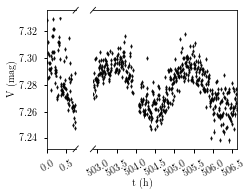

In [273]:
from brokenaxes import brokenaxes

d1_max = max(t[t < 100])
d2_min = min(t[t > 100])

bax = brokenaxes(xlims=((min(t), d1_max),(d2_min, max(t))), wspace=0.2,despine=False)
plt.setp(bax.get_xticklabels(), rotation=30)
bax.errorbar(t, mags, yerr=err, alpha=0.8, fmt='.', c='k', elinewidth=1, markersize=5)
bax.set_xlabel('t (h)')
bax.set_ylabel('V (mag)')

bax.fig.set_size_inches(width, height)
bax.fig.savefig('../docs/project/figs/rawmags.pdf', bbox_inches='tight')

In [281]:
# frequency = np.linspace(1./100, 1./130, 100)
LS = LombScargle(t, mags, dy=err, nterms=1)
frequency, power = LS.autopower()
best_frequency = frequency[np.argmax(power)]
phase = (t * best_frequency) % 2

phase_fit = np.linspace(0, 2, len(mags))
y_fit = LS.model(phase_fit / best_frequency, best_frequency)

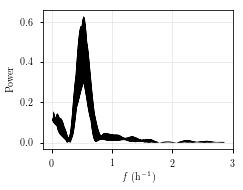

In [282]:
plt.plot(frequency, power, 'k', lw=.1)
plt.grid(True, alpha=.25)
plt.xlabel(r'\textit{f} (h^{-1})')
plt.ylabel('Power')
plt.gcf().set_size_inches(width, height)
plt.savefig('../docs/project/figs/power.pdf', bbox_inches='tight')

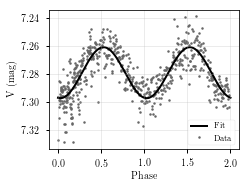

In [283]:
plt.figure()
plt.gca().invert_yaxis()
plt.plot(phase_fit, y_fit, c='k', lw=2, label='Fit', zorder=1)
plt.plot(phase, mags, '.', label='Data', c='.4', zorder=0,markersize=5)
plt.grid(True, alpha=.25)
plt.legend()
plt.xlabel('Phase')
plt.ylabel('V (mag)')
plt.gcf().set_size_inches(width, height)
plt.savefig('../docs/project/figs/fit.pdf', bbox_inches='tight')

In [286]:
s = np.sqrt( np.sum(y_fit - mags)**2/ (len(mags) - 2))
print(s/best_frequency)
print('Best Frequency: {} +- {}'.format(best_frequency, best_frequency * s))
print('Best Period: {}+-{} h   {}+-{} d'.format(1/best_frequency,s/best_frequency, 1/best_frequency/24, s/best_frequency/24))
print('Raw range {} to {} ({} mag)'.format(mags.min(), mags.max(), abs(mags.min() - mags.max())))
print('Fit range {} to {} ({} mag)'.format(y_fit.min(), y_fit.max(), abs(y_fit.min() - y_fit.max())))

0.0530593878051
Best Frequency: 0.5284043241087454 +- 0.014814771612195424
Best Period: 1.8924901905121436+-0.05305938780506204 h   0.07885375793800599+-0.0022108078252109182 d
Raw range 7.238519 to 7.329167 (0.09064799999999984 mag)
Fit range 7.260778297459702 to 7.297430632645647 (0.036652335185944906 mag)
